<a href="https://colab.research.google.com/github/fengyuqi621/intothedata/blob/master/Lec21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jupyter Notebook

This is a Jupyter Notebook, which is a basically just a super fancy Python shell.

You may have "cells" that can either be text (like this one) or executable Python code. Notebooks are really nice because they allow you to rapidly develop Python code by writing small bits of code, testing their output, and moving on to the next bit; this interactive nature of the notebook is a huge plus to professional Python developers. 

It's also nice, because it's really easy to share your code with others and surround it with text to tell a story! 

# Colaboratory
Colaboratory is a service provided by Google to take a Jupyter Notebook (a standard formay of a `.ipynb` file) and let users edit/run the code in the notebook for free! 

This notebook is write-protected so you are not able to edit the  notebook that the whole class will look at, but you are able to open up the notebook in "playground mode" which lets you make edits to a temporary copy of the notebook. If you want to save the changes you made to this notebook, you will have to follow the instructions when you try to save to copy the notebook to your Google Drive. 

# Setup
Make sure you run the following cell(s) before trying to run any the following cells. You do not need to understand what they are doing, it's just a way to make sure there is a file we want to use stored on the computer running this notebook.


In [ ]:
# This takes a little while to run unfortunately
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz 2>/dev/null | tar xz
!apt-get install -qq g++ make
import os
os.chdir('/content/spatialindex-src-1.8.5')
!./configure 2>&1 >/dev/null && make 2>&1 >/dev/null && make install && ldconfig
!pip install -q rtree

In [ ]:
import requests


def save_file(url, file_name):
  r = requests.get(url)
  with open(file_name, 'wb') as f:
    f.write(r.content)

    
save_file('https://courses.cs.washington.edu/courses/cse163/19sp/' +
          'files/lectures/05-13/data.zip', 'data.zip')
save_file('https://courses.cs.washington.edu/courses/cse163/19sp/' +
          'files/lectures/05-13/gz_2010_us_040_00_5m.json', 
          'gz_2010_us_040_00_5m.json')
save_file('https://courses.cs.washington.edu/courses/cse163/19sp/' +
          'files/lectures/05-13/stormhistory.csv', 'stormhistory.csv')
    
!unzip data.zip
!pip install --upgrade geopandas
!pip install --upgrade rtree
!pip install --upgrade pyshp
!pip install --upgrade shapely
!pip install --upgrade descartes

Archive:  data.zip
   creating: data/
  inflating: data/ne_110m_admin_0_countries.shx  
  inflating: data/ne_110m_admin_0_countries.shp  
 extracting: data/ne_110m_admin_0_countries.cpg  
 extracting: data/ne_110m_admin_0_countries.VERSION.txt  
  inflating: data/ne_110m_admin_0_countries.dbf  
  inflating: data/ne_110m_admin_0_countries.README.html  
  inflating: data/ne_110m_admin_0_countries.prj  
     |████████████████████████████████| 931kB 5.1MB/s 
     |████████████████████████████████| 11.8MB 41.0MB/s 
     |████████████████████████████████| 10.1MB 47.1MB/s 
Requirement already up-to-date: rtree in /usr/local/lib/python3.6/dist-packages (0.9.4)
     |████████████████████████████████| 225kB 4.6MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.0-cp36-none-any.whl size=32609 sha256=7260ad4d59de4006d9717e91ec4f64ec87f3078cb0bff622d0e6b6bbc9d60aa3
  Stored in directory: /root/.cache/pip/wheels/a6/0c/de/321b5192ad416b328975a2f0385f72c64db4656501eba7cc1a
Successfully built pyshp
Req

In [ ]:
%matplotlib inline
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

# Dissolve
The first two cells are just review from Lec 20 to plot information about the world in the `countries` dataset.

In [ ]:
countries = geopandas.read_file('data/ne_110m_admin_0_countries.shp')

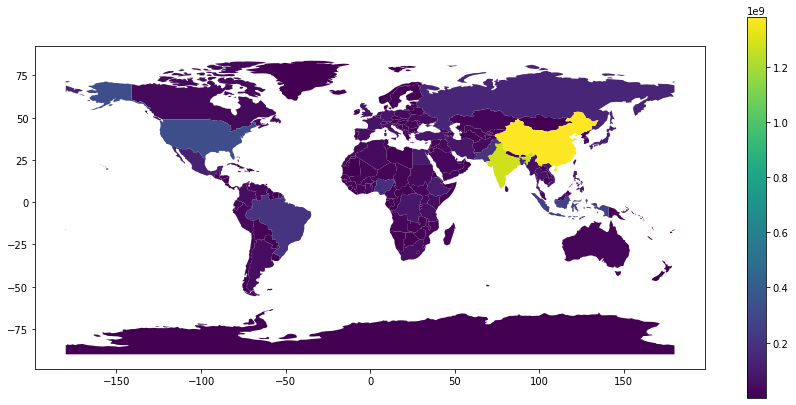

In [ ]:
countries.plot(column='POP_EST', figsize=(15, 7), legend=True)

When we first learned `pandas`, we learned about the `groupby` operation. `geopandas` provides a similar function called `dissolve`. It is basically the same as groupby for the non-geometry column, but will combine all the geometries by overlapping them. One annoying thing about `dissolve` is that it operates on all columns, we we first have to make a smaller `GeoDataFrame` that only has the columns we want to group by or aggregate. 

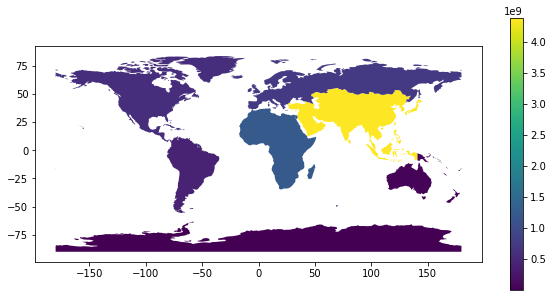

In [ ]:
# Get only the columns we want to aggregate 
populations = countries[['CONTINENT', 'POP_EST', 'geometry']]

# Do the dissolve (groupby)
popluation_by_continent = populations.dissolve(by='CONTINENT', aggfunc='sum')

# Plot this new GeoDataFrame
popluation_by_continent.plot(column='POP_EST', legend=True, figsize=(10, 5))

# Join
We did a practice problem in lecture today where we wanted to use the data below to figure out what join to use. We didn't fully write the code to count the number of ratings for each instructor, but I wanted to include this example here anyays.

In [ ]:
instructors = pd.DataFrame([
    {'name': 'Hunter', 'id': 1},
    {'name': 'Rit', 'id': 2},
    {'name': 'Aleks', 'id': 3}
])

evals = pd.DataFrame([
    {'instructor_id': 2, 'rating': 3},
    {'instructor_id': 3, 'rating': 3},
    {'instructor_id': 2, 'rating': 3}
])

In [ ]:
merged = instructors.merge(evals, left_on='id', right_on='instructor_id', how='left')

# merged is just a DataFrame!

print(merged.groupby('name')['rating'].count()) # groupby count ignores NaN values!

name
Aleks     1
Hunter    0
Rit       2
Name: rating, dtype: int64


# Spatial Join 
Going back to the hurricane data we saw on Monday, we  wanted to highlight the states that the hurricane went through. The first 3 cells are from Lec 20 for recap.

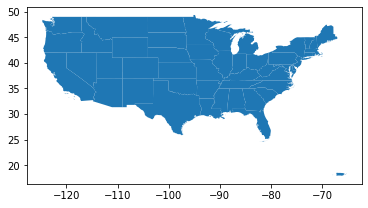

In [ ]:
country = geopandas.read_file("gz_2010_us_040_00_5m.json")
mainland = country[(country['NAME'] != 'Alaska') & (country['NAME'] != 'Hawaii')]
mainland.plot()

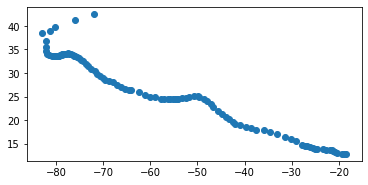

In [ ]:
from shapely.geometry import Point

florence = pd.read_csv('stormhistory.csv')
florence['coordinates'] = [Point(-long, lat) for long, lat in 
                           zip(florence['Long'], florence['Lat'])]
florence = geopandas.GeoDataFrame(florence, geometry='coordinates')
florence.plot()

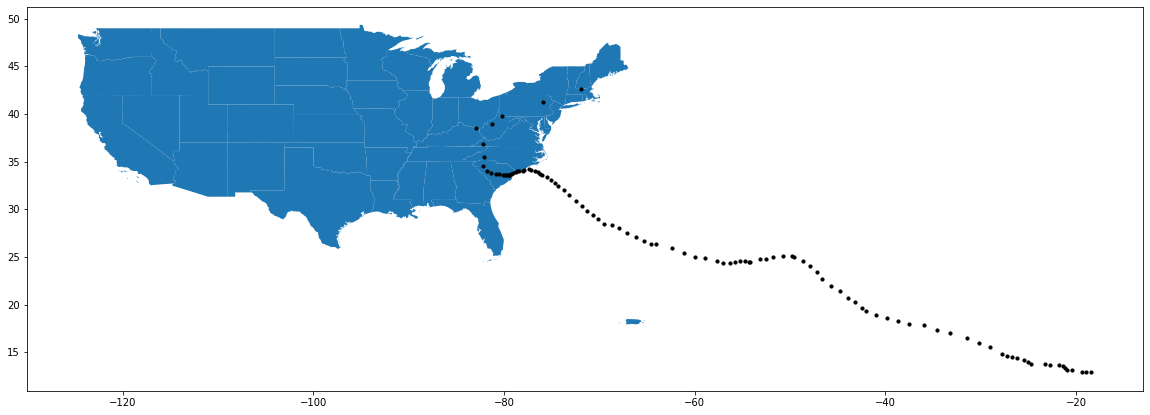

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,10))
mainland.plot(ax=ax)
florence.plot(ax=ax, color='#000000', markersize=10)

The next part was actually finding the states that intersected Hurrican Florence. We want something like a join (where we want to find all the states that "match" the path of florence). A plain old `merge` won't work since we aren't looking for "equals" but rather looking for if Hurricane Florence "intersects" a state. We have to use a special `geopandas` function in this case called `sjoin`.

One question we asked then is what type of join we wanted (inner/left/right/outer). In this case, we want an inner because we only want the states that appear in the path of the hurricane and there is no need to include the others.

Notice that the returned `GeoDataFrame` has the columns of both `GeoDataFrames` used in the join, but keeps the `geometry` of the left table.

In [ ]:
affected_states = geopandas.sjoin(mainland, florence, how='inner', op='intersects')
affected_states.head()

/usr/local/lib/python3.6/dist-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(epsg:4326 != None)
  "(%s != %s)" % (left_df.crs, right_df.crs)


,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry,index_right,AdvisoryNumber,Date,Lat,Long,Wind,Pres,Movement,Type,Name,Received,Forecaster
17,0400000US21,21,Kentucky,,39486.338,"MULTIPOLYGON (((-89.48511 36.49769, -89.49254 ...",100,73,09/17/2018 11:00,38.5,82.9,25,1008,NE at 15 MPH (40 deg),Tropical Depression,FLORENCE,09/17/2018 10:59,NaN
21,0400000US25,25,Massachusetts,,7800.058,"MULTIPOLYGON (((-70.82740 41.60207, -70.82373 ...",104,77,09/18/2018 11:00,42.6,71.9,25,1006,ENE at 25 MPH (70 deg),Post-Tropical Cyclone,Florence,09/18/2018 11:14,Carbin
33,0400000US37,37,North Carolina,,48617.905,"MULTIPOLYGON (((-75.75377 35.19961, -75.74522 ...",83,62,09/14/2018 17:00,34.0,78.6,70,972,W at 3 MPH (270 deg),Tropical Storm,Florence,09/14/2018 16:45,Stewart
33,0400000US37,37,North Carolina,,48617.905,"MULTIPOLYGON (((-75.75377 35.19961, -75.74522 ...",82,61A,09/14/2018 14:00,34.0,78.4,75,968,W at 5 MPH (270 deg),Hurricane,Florence,09/14/2018 13:54,Stewart
33,0400000US37,37,North Carolina,,48617.905,"MULTIPOLYGON (((-75.75377 35.19961, -75.74522 ...",81,61,09/14/2018 11:00,34.0,78.0,80,958,WSW at 3 MPH (245 deg),Hurricane,Florence,09/14/2018 10:42,Stewart


Then, all that's left is to plot things in layers like we saw on Wednesday. We first plot a gray map to see all the states, then highlight the affected ones in blue before plotting the hurricane.

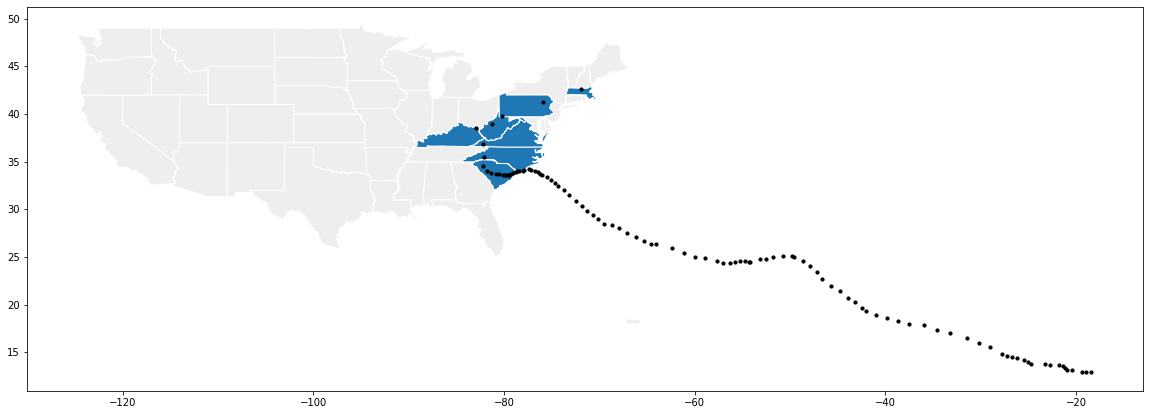

In [ ]:
fig, ax = plt.subplots(1, figsize=(20, 10))

mainland.plot(ax=ax, color='#EEEEEE', edgecolor='#FFFFFF')

affected_states.plot(ax=ax, edgecolor='#FFFFFF')

florence.plot(ax=ax, color='#000000', markersize=10)